In [ ]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib

import ribasim

import ribasim_lumping
from ribasim_lumping.ribasim_model_results import plot_results_basin_ribasim_model, \
    plot_results_basins_ribasim_model, get_ribasim_basin_data_from_model, read_ribasim_model_results

import pandas as pd
import geopandas as gpd
import numpy as np
import pyarrow as pa

import warnings

warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None

In [ ]:
%load_ext autoreload
%autoreload 2

#### BASIC SETTINGS

In [ ]:
# define network name, base dir
network_name = "tki_hooge_raam"
base_dir = Path("..\\..\\..\\ribasim_lumping_data\\")

# directory D-HYDRO basis calculations
dhydro_basis_dir = Path(base_dir, network_name, "2_dhydro\\basis\\")

# directory D-HYDRO results calculations
dhydro_results_dir = Path(base_dir, network_name, "2_dhydro\\results\\")

# directory results
results_dir = Path(base_dir, network_name, "3_ribasim\\")

# batch file used to calculate volume D-Hydro module per GridPoint
dhydro_volume_tool_bat_file = Path(r"c:\Program Files\Deltares\D-HYDRO Suite 2023.03 1D2D\plugins\DeltaShell.Dimr\kernels\x64\dflowfm\scripts\run_dfm_volume_tool.bat")
dhydro_volume_tool_increment = 0.1

# link to ribasim_executable
path_ribasim_executable = "..\\..\\..\\ribasim_cli_windows\\bin\\ribasim.exe"

In [ ]:
# Create networkanalysis
network = ribasim_lumping.create_ribasim_lumping_network(
    base_dir=base_dir,
    name=network_name,
    dhydro_basis_dir=dhydro_basis_dir,
    dhydro_results_dir=dhydro_results_dir,
    results_dir=results_dir,
    path_ribasim_executable=path_ribasim_executable,
    crs=28992
)

#### READ NETWORK AND SIMULATION DATA

In [ ]:
# Read network data and extract all objects (weirs/pumps/laterals/confluences/bifurcations)
network.add_basis_network(
    source_type="dhydro",
    set_name="winter",
    model_dir=Path(dhydro_basis_dir, "winter"),
    simulation_name="HoogeRaamRibasim_afvoergolf.dsproj_data",
    dhydro_volume_tool_bat_file=dhydro_volume_tool_bat_file, 
    dhydro_volume_tool_force=False,
    dhydro_volume_tool_increment=dhydro_volume_tool_increment
);

In [ ]:
# Select simulation sets and extract all data using xugrid/ugrid
network.add_simulation_set(
    source_type="dhydro",
    set_name="winter",
    model_dir=Path(dhydro_results_dir, "winter"),
    simulation_names=["0_01", "0_02", "0_05", "0_075", "0_1", "0_2", "0_5", "0_75", "1_0", "1_5", "2_0"],
    simulation_ts=[-1],
);

#### SETUP SIMULATION

In [ ]:
simulation_code = "test_subgrid_20240131"
set_name = "winter"

##### READ AREAS

In [ ]:
# Load areas (discharge units: afwaterende eenheden)
areas_dir               = Path(base_dir, network_name, "1_data", "areas")
areas_file_name         = "afwateringseenheden2023_v1_HoogeRaam.shp"
areas_id_column         = "CODE"
network.read_areas(
    areas_file_path=Path(areas_dir, areas_file_name), 
    areas_id_column=areas_id_column
)

In [ ]:
network.plot();

##### DEFINE DISCHARGE OVER TIME (LITER / SECOND / HECTARE)
Defition Lateral inflow
- method_laterals = 1: laterals basis network
- method_laterals = 2: laterals per discharge area > required: run function read_areas_laterals_timeseries(path_to_excel)
- method_laterals = 3: homogeneous discharge > required: define laterals_drainage_per_ha (pandas series)

In [ ]:
network.method_laterals = 1

fig, ax = plt.subplots(figsize=(7,4))
network.laterals_data.sum(axis=1).plot(ax=ax);

In [ ]:
network.method_boundaries

##### DEFINE SPLIT-NODES WITHIN THE NETWORK

In [ ]:
network.add_split_nodes(
    weirs=False,
    pumps=False,
    uniweirs=False,
    culverts=False,
    edges=False,
    structures_ids_to_include=[
        "105HOO", "105LHW", "105HOE", "105ACS", "105BZS", "105BRG", "105PCS", 
        "105OMS", "105ADS", "105PVS", "105NBG", "105AES", "105LBW", "105BGA", 
        "105MKP", "105PDS", "105AFT", "105GLS", "105ADH", "105WEV", "105SBG", 
        "105OMK", "105NXV", "105VLW", "105PDT", "105OUS", "105OVS", "105OQS", 
        "105OXS", "105AHS", "105PET", "105PGS", "105PES", "105BZV", "105ABS", 
        "105PCL", "105BRM", "105PBK", "105SAW", "105NXS", "105ONS", "105BFA", 
        "105MPD", "105PLW", "105ADB", "105PBR", "105HHT", "105AKS", "105DHA", 
        "105PAS", "105RKW", "105ADK", "105PDR", "105AFS", "105AGS", "105BUS", 
        "105ZAN", 
    ],
    structures_ids_to_exclude=[],
    edge_ids_to_include=[],
    edge_ids_to_exclude=[],
);

##### DEFINE TRANSLATION OF SPLIT-NODES TO RIBASIM-NODES (per type of structure or per individual split-node)

In [ ]:
split_node_type_conversion = dict(
    weir="TabulatedRatingCurve",
    uniweir="TabulatedRatingCurve",
    pump="Pump",
    culvert="TabulatedRatingCurve",
    edge="ManningResistance",
    orifice="Outlet",
    boundary_connection="ManningResistance"
)
split_node_id_conversion = {}

##### GENERATE RIBASIM LUMPING NETWORK BASED ON DHYDRO NETWORK

In [ ]:
network.generate_ribasim_lumping_network(
    simulation_code=simulation_code,
    split_node_type_conversion=split_node_type_conversion,
    split_node_id_conversion=split_node_id_conversion,
);

##### GENERATE RIBASIM MODEL AND EXPORT TO GEOPACKAGE

In [ ]:
ribasim_model = network.generate_ribasim_model_complete(
    set_name=set_name,
    saveat=3600,
    results_subgrid=True
)

##### ************ RUN MODEL BY RUNNING BAT-FILE ************

##### READ RESULTS FROM MODEL AND CREATE PLOTS

In [ ]:
ribasim_results = read_ribasim_model_results(
    simulation_path=network.simulation_path
)

In [ ]:
# for basin_no in ribasim_model.basin.state.df.node_id.values:
#     ribasim_model, ribasim_results, basin_results, fig, axes = plot_results_basin_ribasim_model(
#         ribasim_model=ribasim_model,
#         ribasim_results=ribasim_results,
#         basin_no=basin_no
#     );

: 

In [21]:
import geopandas as gpd
import pandas as pd
from pathlib import Path

ribasim_dir = r"..\\4_ribasim"
bookmarks_path = Path(ribasim_dir, "bookmarks.xml")
bookmarks = pd.read_xml(bookmarks_path)
bookmarks["x"] = (bookmarks["xmin"] + bookmarks["xmax"])/2.0
bookmarks["y"] = (bookmarks["ymin"] + bookmarks["ymax"])/2.0
bookmarks = gpd.GeoDataFrame(bookmarks, geometry=gpd.points_from_xy(bookmarks.x, bookmarks.y), crs=28992)
bookmarks[["name", "project", "geometry"]].to_file(Path(ribasim_dir, "hotspots.gpkg"), layer="hotspots", driver="GPKG")

<Axes: >

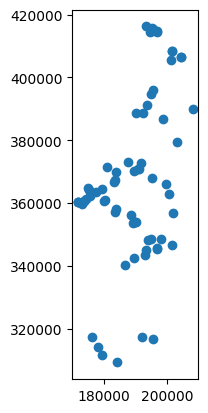